# **Bài tập lớn: Phân tích biến động giá cổ phiếu Intel (INTC)**
## **Môn học: Lập trình xử lí dữ liệu với python**
**Sinh viên:**
- Nguyễn Văn Vũ - 24022493


### **I. Thu thập, xử lý dữ liệu và xây dựng tập thông số kỹ thuật cơ bản**
1. Tất cả các thư viện cần dùng

In [216]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

2. Thu thập dữ liệu

In [217]:
symbols = ['INTC', 'AMD', 'NVDA', 'QCOM']
start = datetime(2023, 7, 1)
end = datetime(2024, 12, 31)

all_data = []
for symbol in symbols:
    df = yf.Ticker(symbol).history(start=start, end=end).reset_index()
    df['Symbol'] = symbol  
    all_data.append(df)
merged_df = pd.concat(all_data, ignore_index=True)

merged_df.to_csv("data/data.csv", index=False)

                       Date       Open       High        Low      Close  \
0 2023-07-03 00:00:00-04:00  32.870018  33.213025  32.478006  32.948418   
1 2023-07-05 00:00:00-04:00  32.644612  32.664213  31.850791  31.860590   
2 2023-07-06 00:00:00-04:00  31.262774  31.399978  30.753161  31.331375   
3 2023-07-07 00:00:00-04:00  31.360779  31.762589  31.184374  31.213776   
4 2023-07-10 00:00:00-04:00  31.233373  32.174197  31.135370  32.085995   

     Volume  Dividends  Stock Splits Symbol  
0  15753000        0.0           0.0   INTC  
1  37664700        0.0           0.0   INTC  
2  41693600        0.0           0.0   INTC  
3  28345700        0.0           0.0   INTC  
4  36305700        0.0           0.0   INTC  


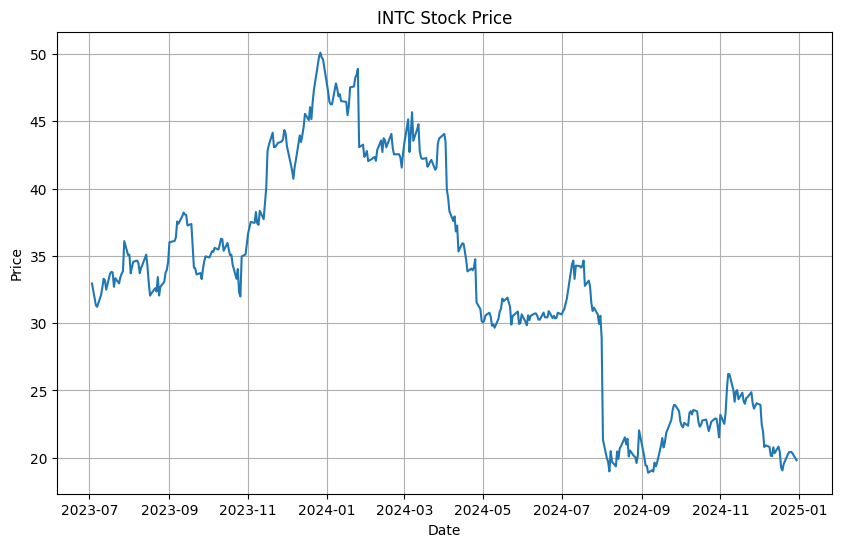

In [218]:
# Kiểm tra 5 dòng đầu
print(merged_df.head())

# Vẽ thử biểu đồ 
df = merged_df[merged_df['Symbol'] == 'INTC'].copy()
symbol = "INTC"  
plt.figure(figsize=(10, 6)) 
sns.lineplot(data=df, x='Date', y='Close')
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

3. Làm sạch và tiền xử lý dữ liệu

In [219]:
df = pd.read_csv("data/data.csv")

# Chuyển cột ngày tháng về định dạng datetime 
df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce') 
df['Date'] = df['Date'].dt.tz_convert(None)  
df['Date'] = df['Date'].dt.normalize()

# Xóa dòng có giá trị bị thiếu (NaN)
df = df.dropna()

# Kiểm tra và loại bỏ bất thường (outliers)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)] 

# Loại bỏ 'Dividends' và 'Stock Splits' vì không ảnh hưởng trực tiếp đến phân tích kỹ thuật giá ngắn và trung hạn
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

df_intc = df[df['Symbol'] == 'INTC']
df_intc.to_csv("data/data_clean.csv", index=False)

df_other = df[df['Symbol'].isin(['AMD', 'NVDA', 'QCOM'])]
df_other.to_csv("data/data_other.csv", index=False)

df.head()


,Date,Open,High,Low,Close,Volume,Symbol
0,2023-07-03,32.870018,33.213025,32.478006,32.948418,15753000,INTC
1,2023-07-05,32.644612,32.664213,31.850791,31.860590,37664700,INTC
2,2023-07-06,31.262774,31.399978,30.753161,31.331375,41693600,INTC
3,2023-07-07,31.360779,31.762589,31.184374,31.213776,28345700,INTC
4,2023-07-10,31.233373,32.174197,31.135370,32.085995,36305700,INTC


4. Tính toán các chỉ số kỹ thuật cơ bản

In [220]:
df = pd.read_csv("data/data_clean.csv", parse_dates=['Date'])

- <small>SMA_20 & SMA_50</small>

In [221]:
# SMA: Simple Moving Average 
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

- <small>EMA_20</small>

In [222]:
# EMA: Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

- <small>RSI_14</small>

In [223]:
# RSI: Relative Strength Index
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI_14'] = compute_rsi(df['Close'])

- <small>OBV</small>

In [224]:
# OBV: On-Balance Volume
df['OBV'] = 0
df.loc[0, 'OBV'] = df.loc[0, 'Volume']  
for i in range(1, len(df)):
    if df.loc[i, 'Close'] > df.loc[i-1, 'Close']:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV'] + df.loc[i, 'Volume']
    elif df.loc[i, 'Close'] < df.loc[i-1, 'Close']:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV'] - df.loc[i, 'Volume']
    else:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV']

- <small>ATR_14</small>

In [225]:
# ATR: Average True Range       
high_low = df['High'] - df['Low']
high_prev_close = abs(df['High'] - df['Close'].shift(1))
low_prev_close = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()
df.drop(columns=['TR'], inplace=True)

In [226]:
df.to_csv("data/data_clean.csv", index=False)
df[['Date', 'Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI_14', 'OBV', 'ATR_14']].head(50)

,Date,Close,SMA_20,SMA_50,EMA_20,RSI_14,OBV,ATR_14
0,2023-07-03,32.948418,NaN,NaN,32.948418,NaN,15753000,NaN
1,2023-07-05,31.860590,NaN,NaN,32.844815,NaN,-21911700,NaN
2,2023-07-06,31.331375,NaN,NaN,32.700678,NaN,-63605300,NaN
3,2023-07-07,31.213776,NaN,NaN,32.559068,NaN,-91951000,NaN
4,2023-07-10,32.085995,NaN,NaN,32.514014,NaN,-55645300,NaN
5,2023-07-11,32.634804,NaN,NaN,32.525517,NaN,-27496500,NaN
6,2023-07-12,33.301224,NaN,NaN,32.599394,NaN,10265700,NaN
7,2023-07-13,33.193424,NaN,NaN,32.655968,NaN,-22480100,NaN
8,2023-07-14,32.487801,NaN,NaN,32.639952,NaN,-52906300,NaN
9,2023-07-17,33.683434,NaN,NaN,32.739332,NaN,-18795100,NaN


### **II. Phân tích và trực quan hóa dữ liệu**

1. So sánh tương quan giữa Intel và các công ty cùng lĩnh vực

- <small>Tính lợi suất ngày</small>

In [227]:
# Intel (INTC)
df_intc= pd.read_csv("data/data_clean.csv", parse_dates=['Date'])
df_intc['Daily_Return'] = df_intc['Close'].pct_change()
df_intc.to_csv("data/data_clean.csv", index=False)

In [228]:
# Các cổ phiếu khác (AMD, NVDA, QCOM)
df_other = pd.read_csv("data/data_other.csv", parse_dates=['Date'])
df_other['Daily_Return'] = df_other['Close'].pct_change()
df_other.to_csv("data/data_other.csv", index=False)

In [229]:
# Trộn file
df_intc = pd.read_csv("data/data_clean.csv", parse_dates=['Date'])
df_intc = df_intc[df_intc['Symbol'] == 'INTC'][['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Symbol', 'Daily_Return']]
df_other = pd.read_csv("data/data_other.csv", parse_dates=['Date'])
df_all = pd.concat([df_intc, df_other], ignore_index=True)


*Giá đóng của theo thời gian*

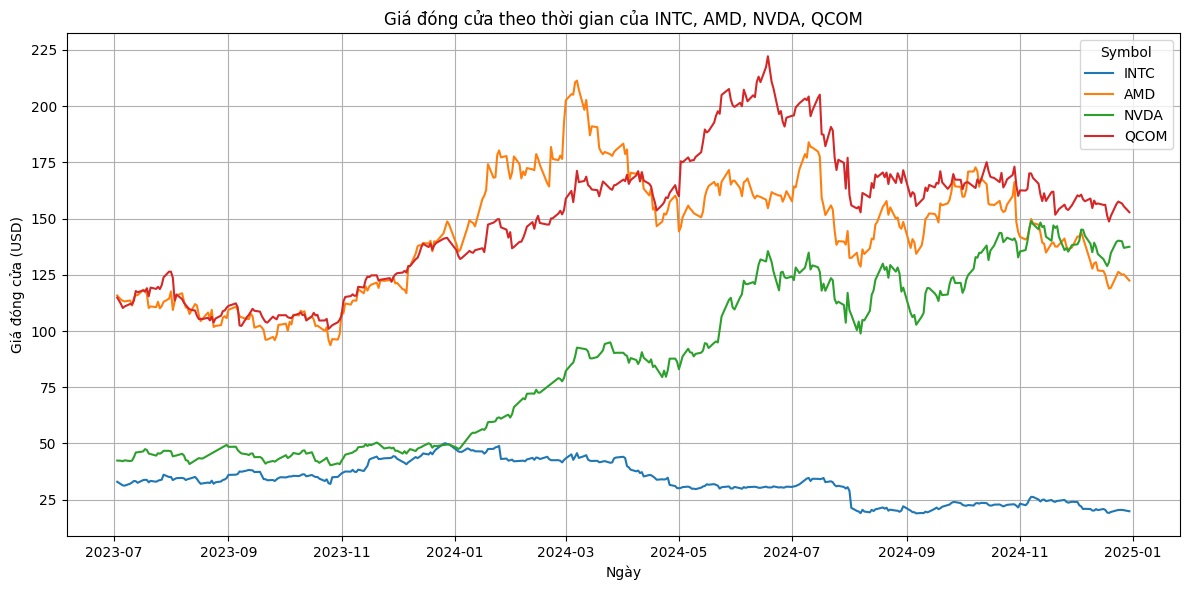

In [230]:
# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_all, x='Date', y='Close', hue='Symbol')
plt.title("Giá đóng cửa theo thời gian của INTC, AMD, NVDA, QCOM")
plt.xlabel("Ngày")
plt.ylabel("Giá đóng cửa (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()

<small> Trong khi các cổ phiếu như NVDA, AMD và QCOM đều ghi nhận mức tăng trưởng rõ rệt, INTC lại cho thấy xu hướng đi ngược thị trường với mức suy giảm nhẹ. Hiệu suất yếu này phản ánh những khó khăn nội tại của Intel trong việc bắt kịp tốc độ đổi mới và cạnh tranh trong lĩnh vực chip bán dẫn và trí tuệ nhân tạo (AI).<small>

*Lợi suất tích lũy*

C:\Users\bossg\AppData\Local\Temp\ipykernel_16852\2050665502.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=final_growth.index, y=final_growth.values, palette='viridis')


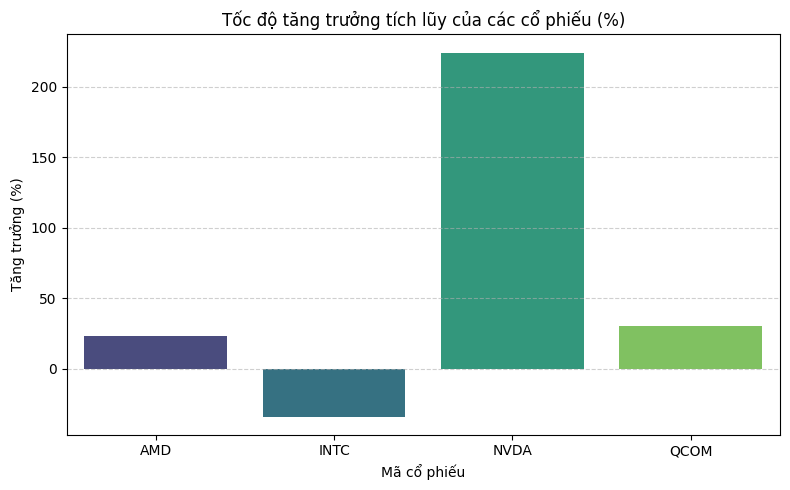

In [231]:
# Pivot lại lợi suất ngày
daily_returns = df_all.pivot(index='Date', columns='Symbol', values='Daily_Return')

# Xử lý dữ liệu thiếu (loại bỏ dòng có mã bị thiếu ngày)
daily_returns = daily_returns.dropna() 

# Tính lợi suất tích lũy
cumulative_return = (1 + daily_returns).cumprod()


# Tính tốc độ tăng trưởng cuối kỳ (%)
final_growth = (cumulative_return.iloc[-1] - 1) * 100

# Vẽ biểu đồ 
plt.figure(figsize=(8, 5))
sns.barplot(x=final_growth.index, y=final_growth.values, palette='viridis')
plt.title("Tốc độ tăng trưởng tích lũy của các cổ phiếu (%)")
plt.ylabel("Tăng trưởng (%)")
plt.xlabel("Mã cổ phiếu")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<small> Biểu đồ cho thấy INTC là cổ phiếu duy nhất ghi nhận tăng trưởng âm, phản ánh sự sụt giảm giá trị trong khi các đối thủ như NVDA, AMD và QCOM đều tăng trưởng tích cực. Điều này thể hiện Intel đang tụt lại trong cuộc đua ngành bán dẫn. <small>

2. Phân tích chi tiết cổ phiếu Intel (INTC)

In [232]:
df_intc = pd.read_csv("data/data_clean.csv", parse_dates=['Date'])

*Ma trận tương quan giữa Close, SMA, RSI*

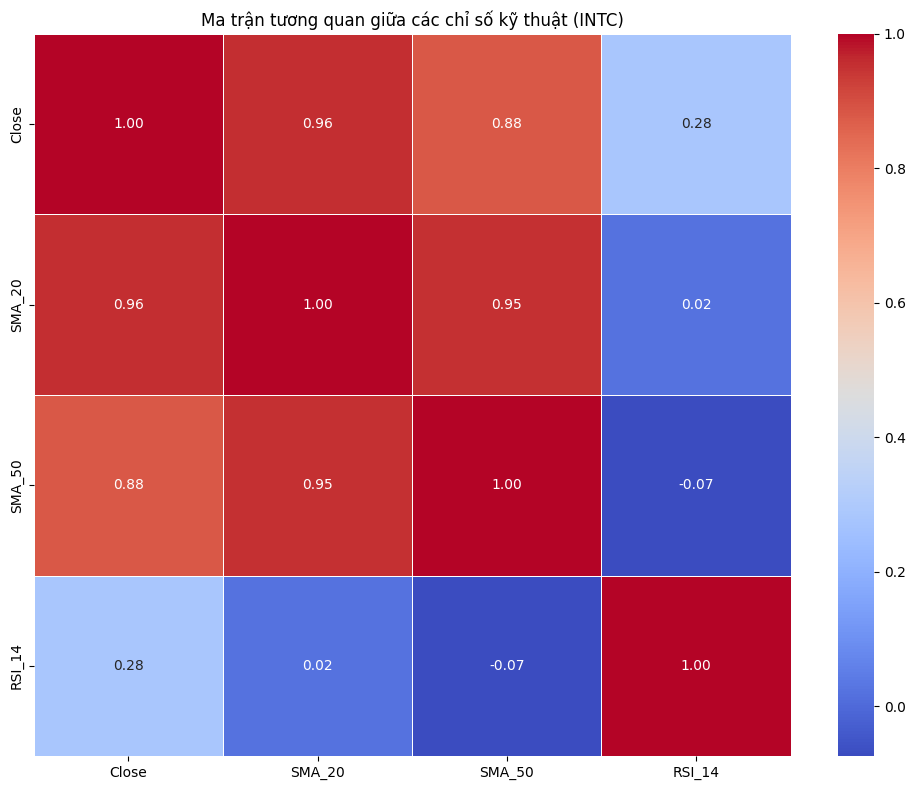

In [233]:
# Lọc chỉ các cột số 
cols = ['Close', 'SMA_20', 'SMA_50', 'RSI_14']
df_corr = df_intc[cols].dropna()

# Tính ma trận tương quan
corr_matrix = df_corr.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Ma trận tương quan giữa các chỉ số kỹ thuật (INTC)")
plt.tight_layout()
plt.show()


*Phân phối lợi suất ngày*

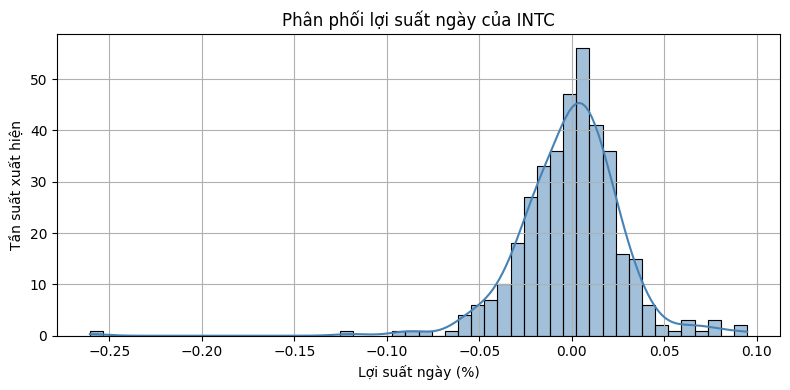

In [234]:
# Vẽ histogram
plt.figure(figsize=(8, 4))
sns.histplot(df_intc['Daily_Return'].dropna(), bins=50, kde=True, color='steelblue')
plt.title("Phân phối lợi suất ngày của INTC")
plt.xlabel("Lợi suất ngày (%)")
plt.ylabel("Tần suất xuất hiện")
plt.grid(True)
plt.tight_layout()
plt.show()

*Giá đóng cửa và các đường trung bình động*

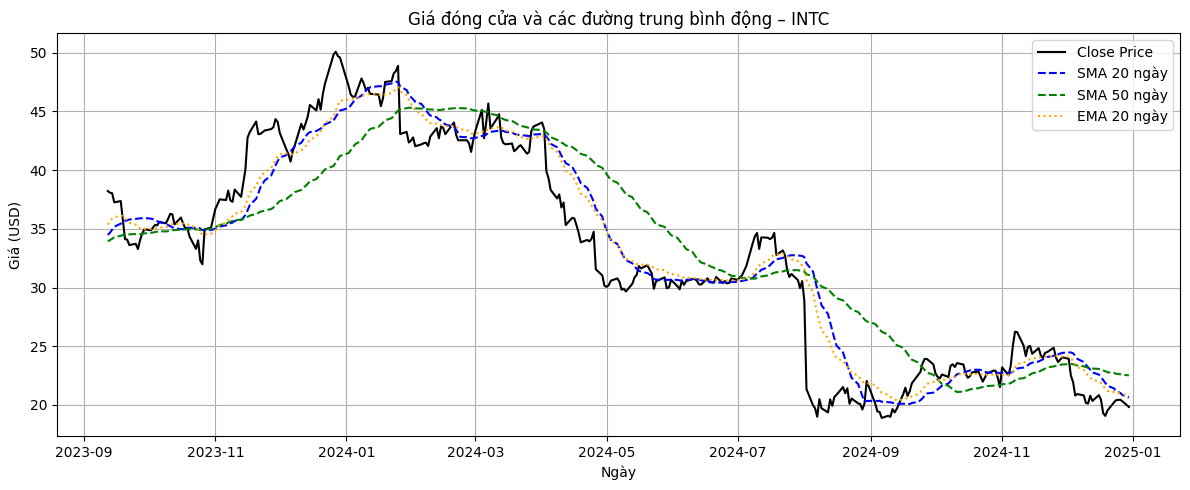

In [235]:
# Lọc dữ liệu của INTC
df = df_intc[df_intc['Symbol'] == 'INTC'].dropna(subset=['SMA_20', 'SMA_50', 'EMA_20'])

# Vẽ biểu đồ
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black', linewidth=1.5)
plt.plot(df['Date'], df['SMA_20'], label='SMA 20 ngày', linestyle='--', color='blue')
plt.plot(df['Date'], df['SMA_50'], label='SMA 50 ngày', linestyle='--', color='green')
plt.plot(df['Date'], df['EMA_20'], label='EMA 20 ngày', linestyle=':', color='orange')

# Thiết lập
plt.title("Giá đóng cửa và các đường trung bình động – INTC")
plt.xlabel("Ngày"); plt.ylabel("Giá (USD)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


*So sánh trực quan Volatility và ATR*

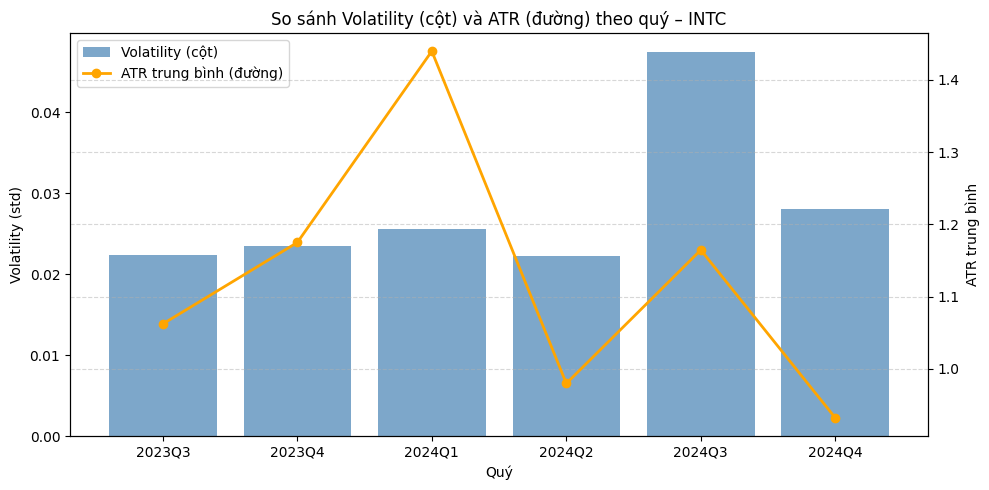

In [236]:
import matplotlib.pyplot as plt

# Lọc dữ liệu INTC
df = df_intc[df_intc['Symbol'] == 'INTC'].copy()
df['Quarter'] = df['Date'].dt.to_period('Q')

# Tính Volatility và ATR trung bình theo quý
summary = df.groupby('Quarter').agg({
    'Daily_Return': 'std',
    'ATR_14': 'mean'
}).reset_index()

summary.columns = ['Quarter', 'Volatility', 'ATR_mean']

# Vẽ biểu đồ
fig, ax1 = plt.subplots(figsize=(10, 5))

# Vẽ cột Volatility
bars = ax1.bar(summary['Quarter'].astype(str), summary['Volatility'],
               color='steelblue', alpha=0.7, label='Volatility (cột)')
ax1.set_ylabel("Volatility (std)", color='black')
ax1.set_xlabel("Quý", color='black')
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis='y', colors='black')

# Vẽ đường ATR trung bình
ax2 = ax1.twinx()
line = ax2.plot(summary['Quarter'].astype(str), summary['ATR_mean'],
                color='orange', marker='o', linewidth=2, label='ATR trung bình (đường)')
ax2.set_ylabel("ATR trung bình", color='black')
ax2.tick_params(axis='y', colors='black')

# Tiêu đề
plt.title("So sánh Volatility (cột) và ATR (đường) theo quý – INTC", color='black')

# Kết hợp chú giải từ cả 2 trục
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



*Đo động lượng thị trường*

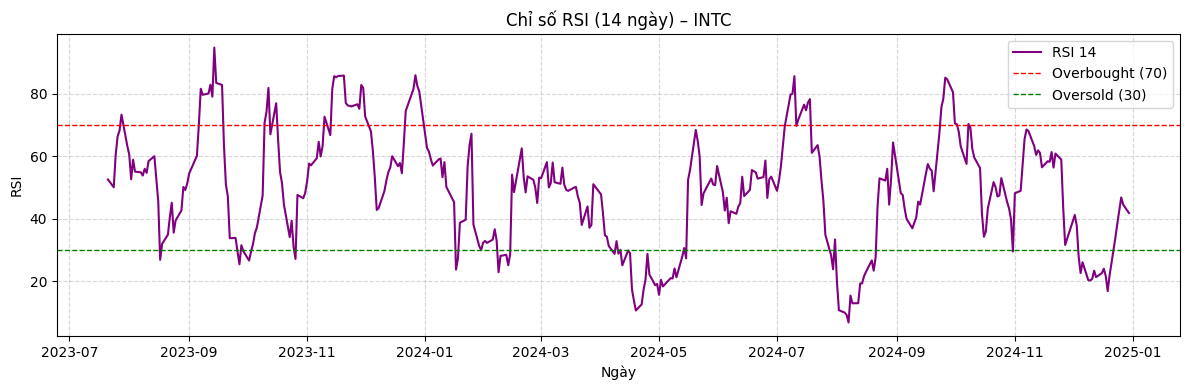

In [237]:
plt.figure(figsize=(12, 4))
plt.plot(df_intc['Date'], df_intc['RSI_14'], color='purple', linewidth=1.5, label='RSI 14')
plt.axhline(70, color='red', linestyle='--', linewidth=1, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=1, label='Oversold (30)')

plt.title("Chỉ số RSI (14 ngày) – INTC", color='black')
plt.xlabel("Ngày", color='black')
plt.ylabel("RSI", color='black')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(colors='black')
plt.tight_layout()
plt.show()


*Phân tích dòng tiền tích lũy*

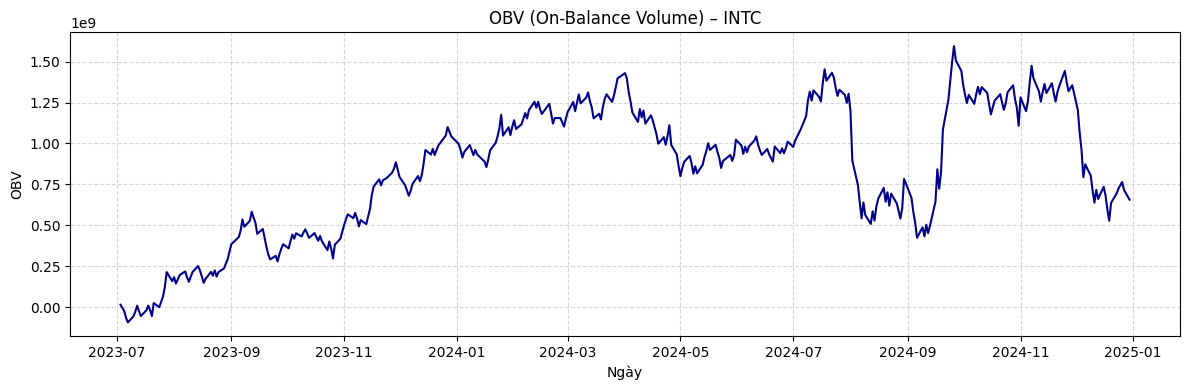

In [238]:
plt.figure(figsize=(12, 4))
plt.plot(df_intc['Date'], df_intc['OBV'], color='darkblue', linewidth=1.5)
plt.title("OBV (On-Balance Volume) – INTC", color='black')
plt.xlabel("Ngày", color='black')
plt.ylabel("OBV", color='black')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(colors='black')
plt.tight_layout()
plt.show()
